# Landslide Detection using CNN with S2 image

## A. CNN Model

In [ ]:
# !pip install "geoai-py"

  Using cached geoai_py-0.16.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached buildingregulariser-0.2.4-py3-none-any.whl.metadata (7.2 kB)
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached ever_beta-0.5.3-py3-none-any.whl.metadata (18 kB)
  Using cached geopandas-1.1.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
  Using cached jupyter_server_proxy-4.4.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached localtileserver-0.10.6-py3-none-any.whl.metadata (5.2 kB)
  Using cached mapclassify-2.10.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached maplibre-0.3.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached planetary_computer-1.0.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached pystac_client-0.9.0-py3-none-any.whl.metadat

In [ ]:
import os
import re

import geoai
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

from libs.utils import get_device
device = get_device()

### Training from [Landslide Segmentation](https://www.kaggle.com/datasets/niyarrbarman/landslide-divided)

This dataset is a simplified version, and originally made by IARAI for landslide4sense 2022.

In [28]:
out_folder = './data/Landslide_Segmentation'

In [31]:
# Test train_segmentation_model with automatic size detection
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/train/images",
    labels_dir=f"{out_folder}/train/masks",
    output_dir=f"{out_folder}/train/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,  # landslide and non-landslide
    batch_size=8,
    num_epochs=50,
    learning_rate=0.0005,
    val_split=0.2,
    verbose=True,
    early_stopping_patience=10,
    device=device
)

Using device: mps
Found 1781 image files and 1781 label files
Training on 1424 images, validating on 357 images
Checking image sizes for compatibility...
All sampled images have the same size: (128, 128)
No resizing needed.
Testing data loader...
Data loader test passed.
Starting training with unet + resnet34
Model parameters: 24,436,514
Epoch: 1, Batch: 1/178, Loss: 0.4505, Time: 0.21s
Epoch: 1, Batch: 11/178, Loss: 0.2257, Time: 1.61s
Epoch: 1, Batch: 21/178, Loss: 0.1290, Time: 1.62s
Epoch: 1, Batch: 31/178, Loss: 0.1581, Time: 1.60s
Epoch: 1, Batch: 41/178, Loss: 0.1163, Time: 1.60s
Epoch: 1, Batch: 51/178, Loss: 0.1141, Time: 1.60s
Epoch: 1, Batch: 61/178, Loss: 0.0697, Time: 1.60s
Epoch: 1, Batch: 71/178, Loss: 0.0794, Time: 1.60s
Epoch: 1, Batch: 81/178, Loss: 0.0938, Time: 1.60s
Epoch: 1, Batch: 91/178, Loss: 0.0881, Time: 1.60s
Epoch: 1, Batch: 101/178, Loss: 0.0757, Time: 1.61s
Epoch: 1, Batch: 111/178, Loss: 0.0899, Time: 1.61s
Epoch: 1, Batch: 121/178, Loss: 0.0859, Time: 1

### Evaluate

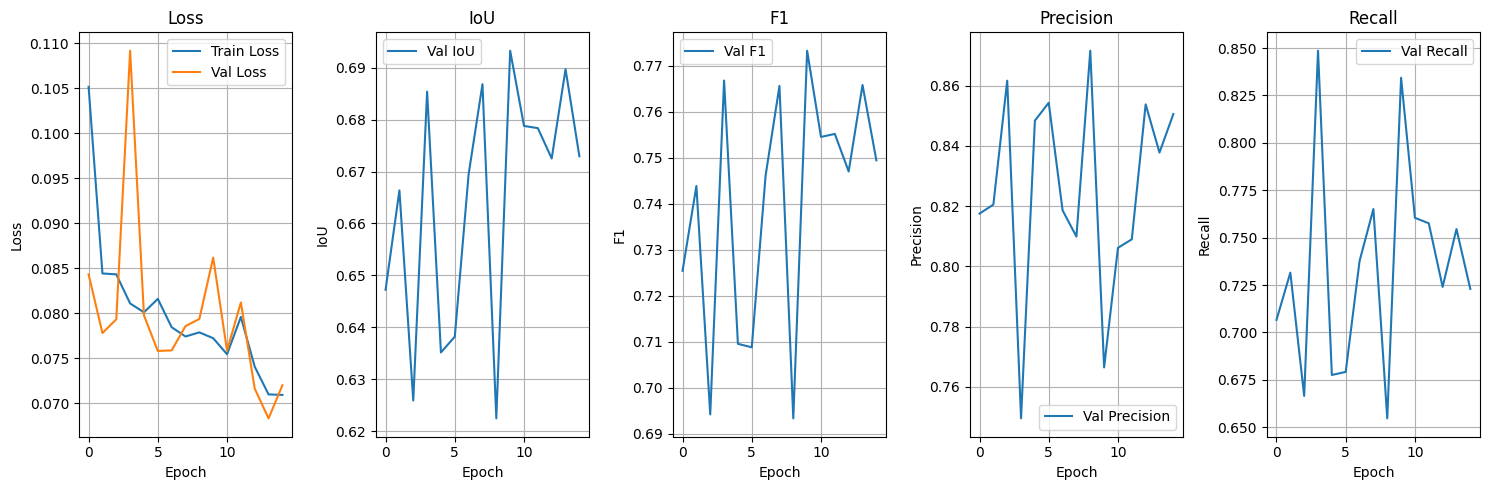


=== Performance Metrics Summary ===
IoU     - Best: 0.6933 | Final: 0.6730
F1      - Best: 0.7733 | Final: 0.7494
Precision - Best: 0.8715 | Final: 0.8505
Recall  - Best: 0.8486 | Final: 0.7230
Val Loss - Best: 0.0683 | Final: 0.0720



,epoch,train_loss,val_loss,val_iou,val_f1,val_precision,val_recall
0,1,0.105182,0.084311,0.647220,0.725406,0.817512,0.706619
1,2,0.084415,0.077785,0.666384,0.743866,0.820493,0.731526
2,3,0.084315,0.079313,0.625885,0.694176,0.861602,0.666504
3,4,0.081075,0.109196,0.685417,0.766792,0.749585,0.848611
4,5,0.080093,0.079751,0.635149,0.709531,0.848349,0.677557
5,6,0.081588,0.075789,0.638192,0.708773,0.854292,0.679167
6,7,0.078433,0.075857,0.669510,0.746131,0.818583,0.737644
7,8,0.077401,0.078552,0.686851,0.765629,0.809888,0.765090
8,9,0.077859,0.079353,0.622445,0.693327,0.871547,0.654673
9,10,0.077211,0.086181,0.693302,0.773277,0.766480,0.834331


In [30]:
model_path = f"{out_folder}/train/unet_models/best_model.pth"

history_path = f"{out_folder}/train/unet_models/training_history.pth"
geoai.plot_performance_metrics(
    history_path=history_path,
    figsize=(15, 5),
    verbose=True,
)

### Run model on dataset sample

In [33]:
def evaluate_set(model_path, data_dir):
    images_dir = f"{data_dir}/images"
    # masks_dir = f"{data_dir}/masks"
    predictions_dir = f"{data_dir}/predictions"
    geoai.semantic_segmentation_batch(
        input_dir=images_dir,
        output_dir=predictions_dir,
        model_path=model_path,
        architecture="unet",
        encoder_name="resnet34",
        num_channels=3,
        num_classes=2,
        window_size=512,
        overlap=256,
        batch_size=4,
        quiet=True,
    )

In [34]:
test_dir = './data/Landslide_Segmentation/validation'
evaluate_set(model_path, test_dir)

Found 199 image files to process
Processing file 1/199: image_100.png
Processing file 2/199: image_1056.png
Processing file 3/199: image_1059.png
Processing file 4/199: image_1064.png
Processing file 5/199: image_1090.png
Processing file 6/199: image_1094.png
Processing file 7/199: image_1095.png
Processing file 8/199: image_1098.png
Processing file 9/199: image_1100.png
Processing file 10/199: image_1138.png
Processing file 11/199: image_1146.png
Processing file 12/199: image_1148.png
Processing file 13/199: image_1150.png
Processing file 14/199: image_1174.png
Processing file 15/199: image_1177.png
Processing file 16/199: image_1178.png
Processing file 17/199: image_1191.png
Processing file 18/199: image_12.png
Processing file 19/199: image_1221.png
Processing file 20/199: image_1277.png
Processing file 21/199: image_1295.png
Processing file 22/199: image_1317.png
Processing file 23/199: image_1318.png
Processing file 24/199: image_1319.png
Processing file 25/199: image_1346.png
Proc

### Test on Evaluation set

In [ ]:
def calculate_confusion_matrix(masks_dir, predictions_dir):
    """
    Calculate confusion matrix for semantic segmentation results
    
    Args:
        masks_dir: Directory containing ground truth masks
        predictions_dir: Directory containing prediction masks
    """
    all_true = []
    all_pred = []
    
    # Get all mask files
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.tif'))])
    
    pattern = re.compile(r'mask_(\d+)\.png')
    
    for mask_file in mask_files:
        number = pattern.search(mask_file).group(1)
        predict_mask_file = f'image_{number}_mask.png'
        
        # Load ground truth mask
        true_mask_path = os.path.join(masks_dir, mask_file)
        true_mask_img = Image.open(true_mask_path)
        
        # Convert to grayscale/single channel if needed (handles RGBA images)
        if true_mask_img.mode in ('RGBA', 'RGB', 'LA'):
            true_mask_img = true_mask_img.convert('L')
        
        true_mask = np.array(true_mask_img)
        
        # Load predicted mask
        pred_mask_path = os.path.join(predictions_dir, predict_mask_file)
        if not os.path.exists(pred_mask_path):
            print(f"Warning: Prediction not found for {pred_mask_path}")
            continue
        
        pred_mask_img = Image.open(pred_mask_path)
        
        # Convert to grayscale if needed
        if pred_mask_img.mode in ('RGBA', 'RGB', 'LA'):
            pred_mask_img = pred_mask_img.convert('L')
        
        pred_mask = np.array(pred_mask_img)
        
        # Flatten and append
        all_true.extend(true_mask.flatten())
        all_pred.extend(pred_mask.flatten())
    
    # Convert to numpy arrays
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    
    print(f"Total samples: {len(all_true)}")
    print(f"Unique values in ground truth: {np.unique(all_true)}")
    print(f"Unique values in predictions: {np.unique(all_pred)}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_true, all_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Landslide', 'Landslide'],
                yticklabels=['Non-Landslide', 'Landslide'])
    plt.title('Confusion Matrix - Landslide Segmentation')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    print("\nClassification Report:")
    print(classification_report(all_true, all_pred, 
                                target_names=['Non-Landslide', 'Landslide']))
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    print(f"\nAdditional Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"IoU (Intersection over Union): {iou:.4f}")
    
    return cm

Total samples: 3260416
Unique values in ground truth: [  0 255]
Unique values in predictions: [  0 255]


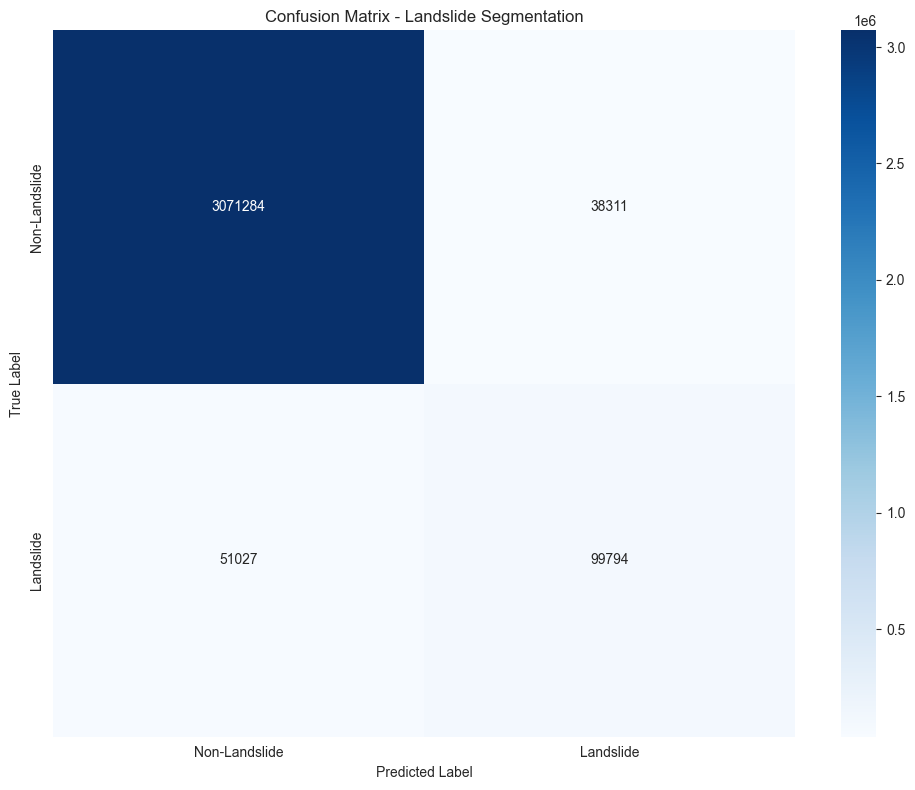


Classification Report:
               precision    recall  f1-score   support

Non-Landslide       0.98      0.99      0.99   3109595
    Landslide       0.72      0.66      0.69    150821

     accuracy                           0.97   3260416
    macro avg       0.85      0.82      0.84   3260416
 weighted avg       0.97      0.97      0.97   3260416


Additional Metrics:
Accuracy: 0.9726
Precision: 0.7226
Recall: 0.6617
F1-Score: 0.6908
IoU (Intersection over Union): 0.5276
               precision    recall  f1-score   support

Non-Landslide       0.98      0.99      0.99   3109595
    Landslide       0.72      0.66      0.69    150821

     accuracy                           0.97   3260416
    macro avg       0.85      0.82      0.84   3260416
 weighted avg       0.97      0.97      0.97   3260416


Additional Metrics:
Accuracy: 0.9726
Precision: 0.7226
Recall: 0.6617
F1-Score: 0.6908
IoU (Intersection over Union): 0.5276


In [76]:
test_dir = './data/Landslide_Segmentation/validation'
# Calculate confusion matrix for validation set
masks_dir = f"{test_dir}/masks"
predictions_dir = f"{test_dir}/predictions"

cm = calculate_confusion_matrix(masks_dir, predictions_dir)

#### Visualize results

In [69]:
def visualize_segmentation_evaluation(img, gt_mask, pred_mask, save_path, figsize=(15, 5)):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    return geoai.plot_prediction_comparison(
        original_image=img,
        ground_truth_image=gt_mask,
        prediction_image=pred_mask,
        titles=["Original", "Prediction", "Ground Truth"],
        figsize=(15, 5),
        save_path=save_path,
        show_plot=True,
        indexes=[0, 1, 2],  # Assuming RGB images
        divider=255,
    )

Plot saved to: ./data/Landslide_Segmentation/validation/segmentation_comparison_image_8/image_8.png


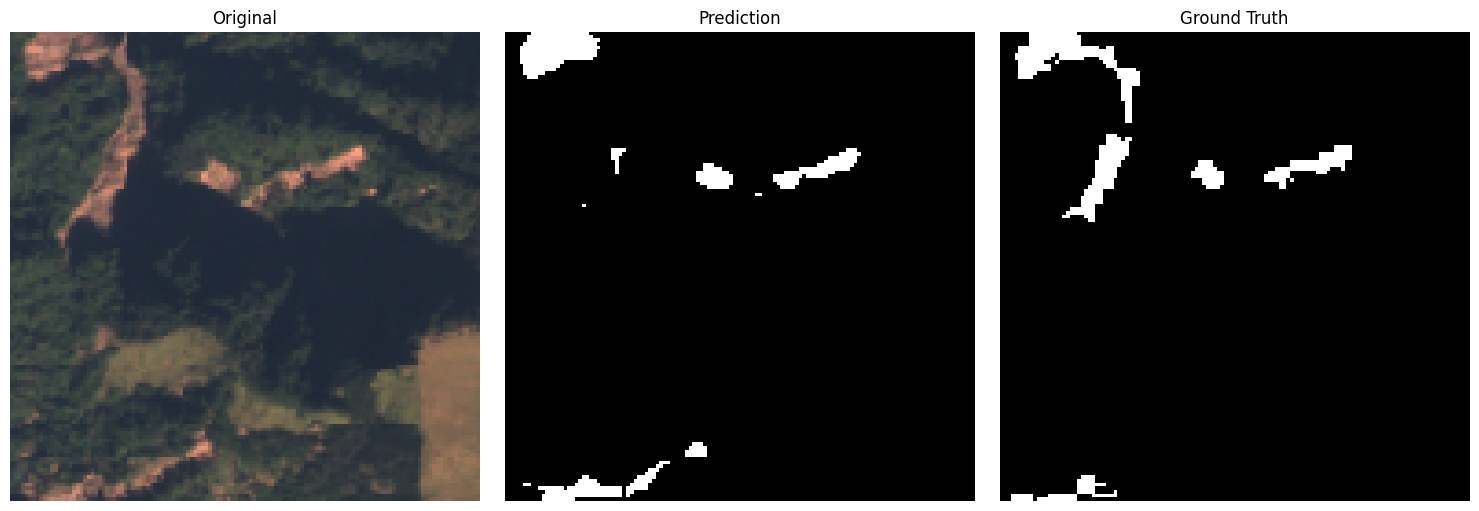

In [ ]:
fig = visualize_segmentation_evaluation(
    f"{test_dir}/images/image_8.png",
    f"{test_dir}/masks/mask_8.png",
    f"{test_dir}/predictions/image_8_mask.png",
    f"{test_dir}/segmentation_comparison_image_8/image_8.png",
    figsize=(15, 5)
)

## Auckland data

In [77]:
auckland_dir = './data/2-data-explore-events'
evaluate_set(model_path, auckland_dir)

Found 152 image files to process
Processing file 1/152: 0_174.701880487593_-36.931306466746_2023-02-13_2023-03-06.png
Processing file 2/152: 10_174.684934100793_-36.7981335088127_2023-01-26_2023-02-16.png
Processing file 3/152: 11280_174.543881026625_-36.564693822369_2023-01-29_2023-02-19.png
Processing file 1/152: 0_174.701880487593_-36.931306466746_2023-02-13_2023-03-06.png
Processing file 2/152: 10_174.684934100793_-36.7981335088127_2023-01-26_2023-02-16.png
Processing file 3/152: 11280_174.543881026625_-36.564693822369_2023-01-29_2023-02-19.png
Processing file 4/152: 11323_174.551195691389_-36.562980250311_2023-01-29_2023-02-19.png
Processing file 5/152: 11544_174.528176529747_-36.5638294879423_2023-01-29_2023-02-19.png
Processing file 6/152: 11545_174.524861366025_-36.5652703977627_2023-01-29_2023-02-19.png
Processing file 7/152: 11637_174.521782810722_-36.5659641834053_2023-01-29_2023-02-19.png
Processing file 4/152: 11323_174.551195691389_-36.562980250311_2023-01-29_2023-02-19.p

In [72]:
def visualize_segmentation_results(img_path, pred_img_path):
    # Set seaborn style
    sns.set_style("whitegrid")

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Load and display original image
    img = Image.open(img_path)
    axes[0].imshow(img)
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Load and display prediction mask
    pred_img = Image.open(pred_img_path)
    axes[1].imshow(pred_img, cmap='gray')
    axes[1].set_title('Prediction Mask', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

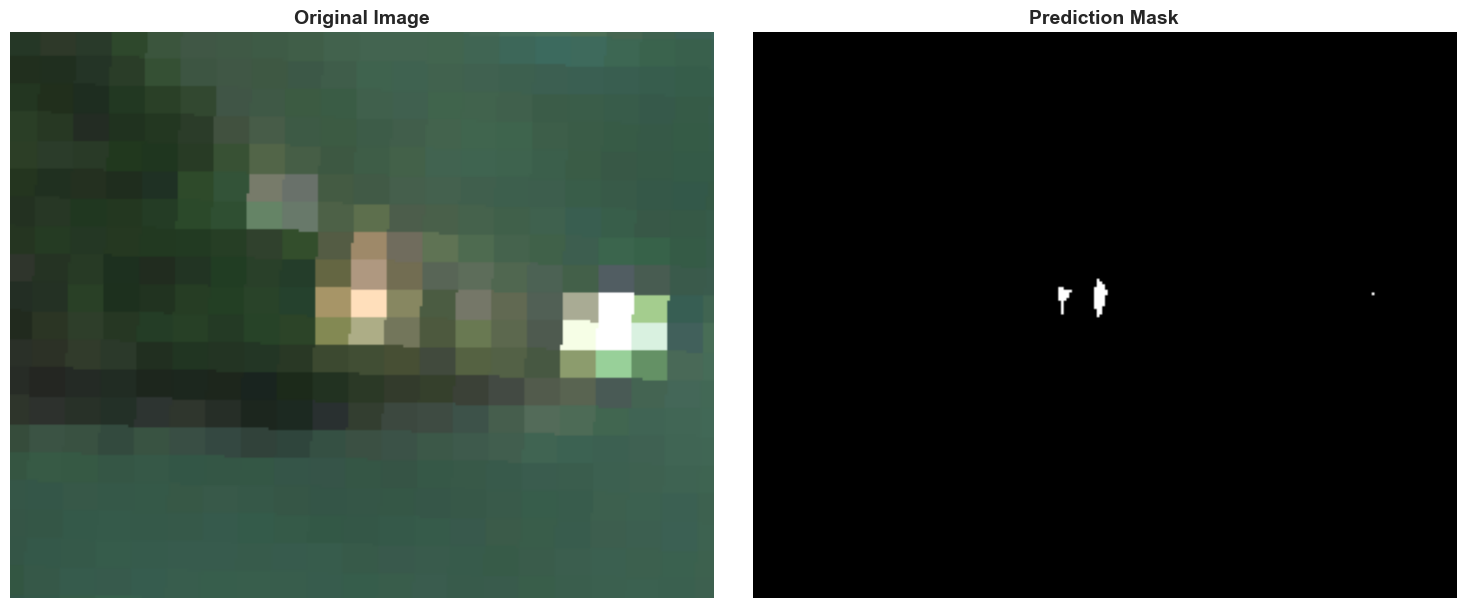

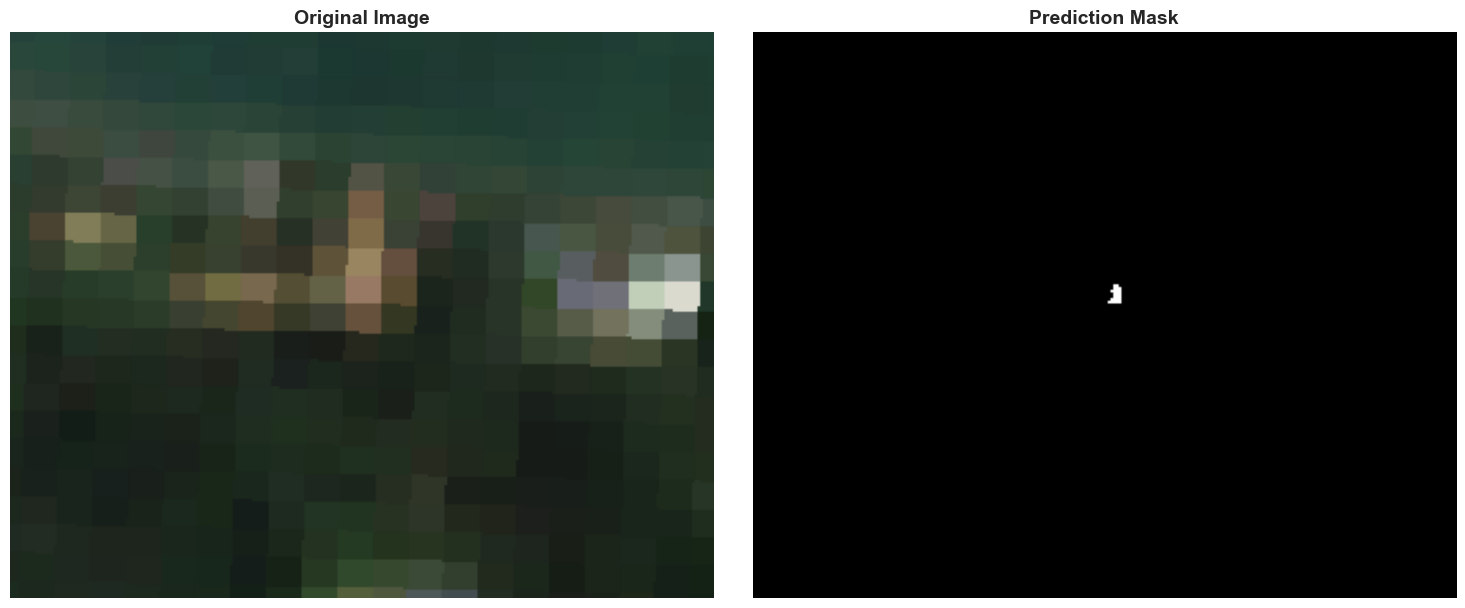

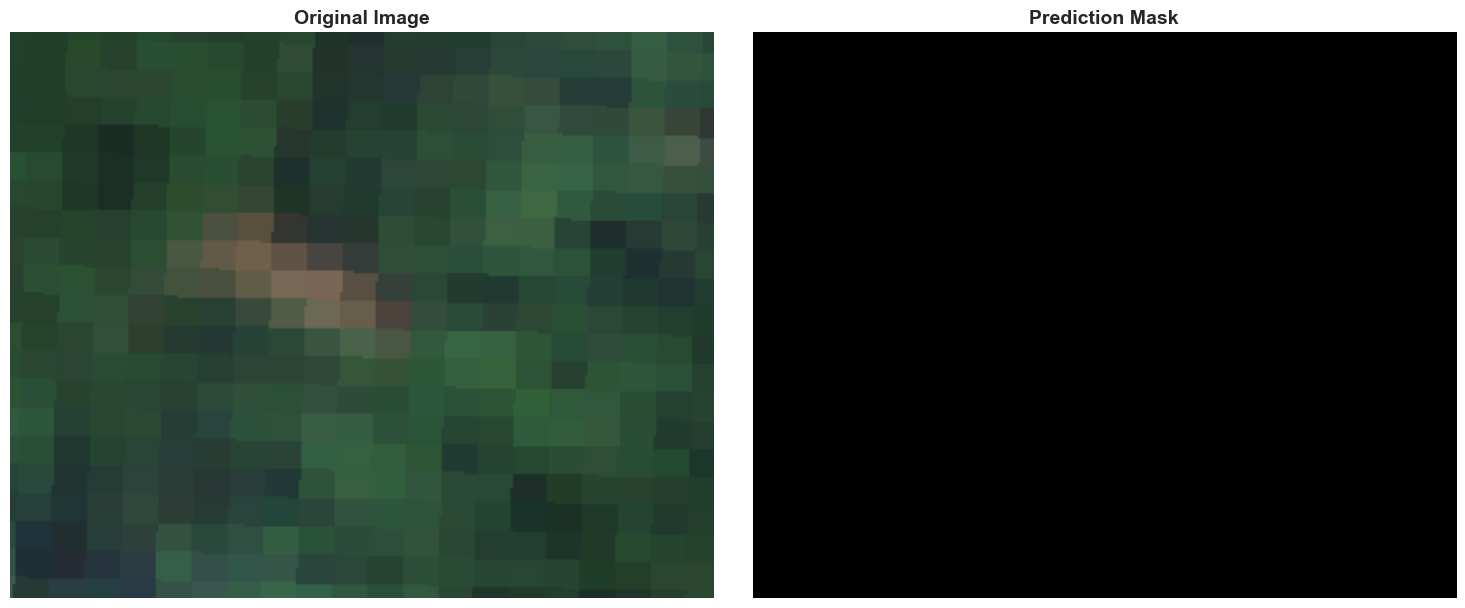

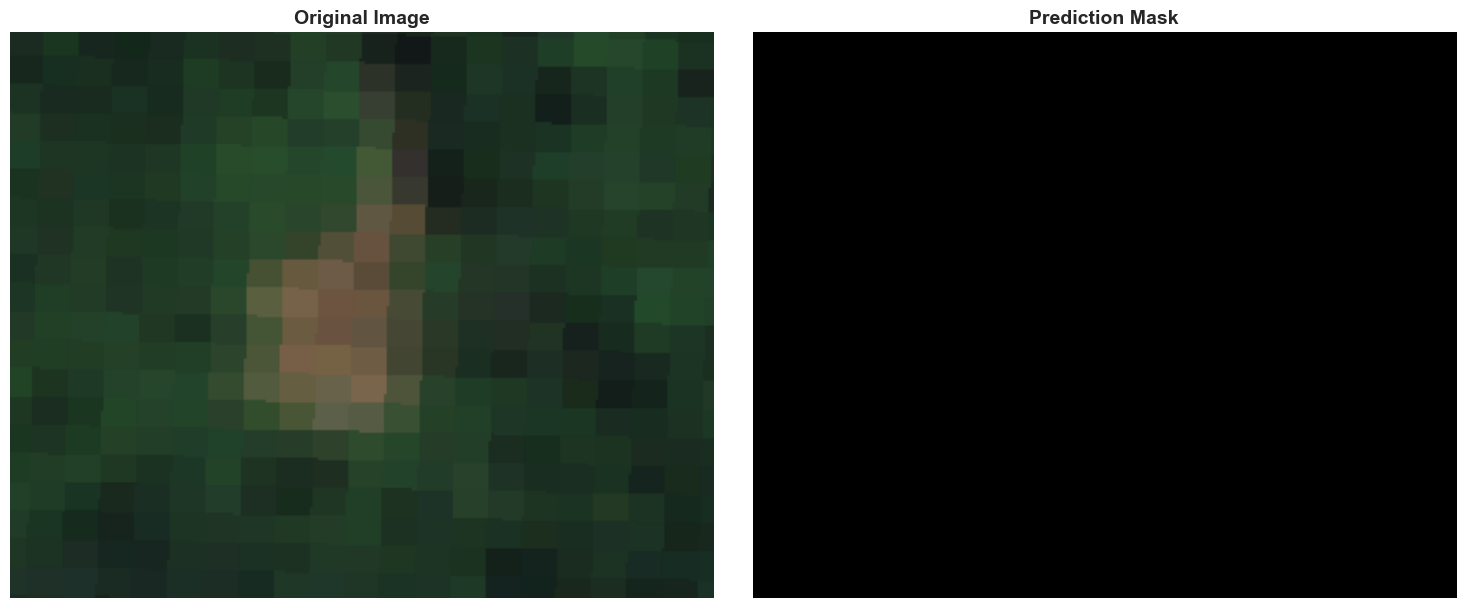

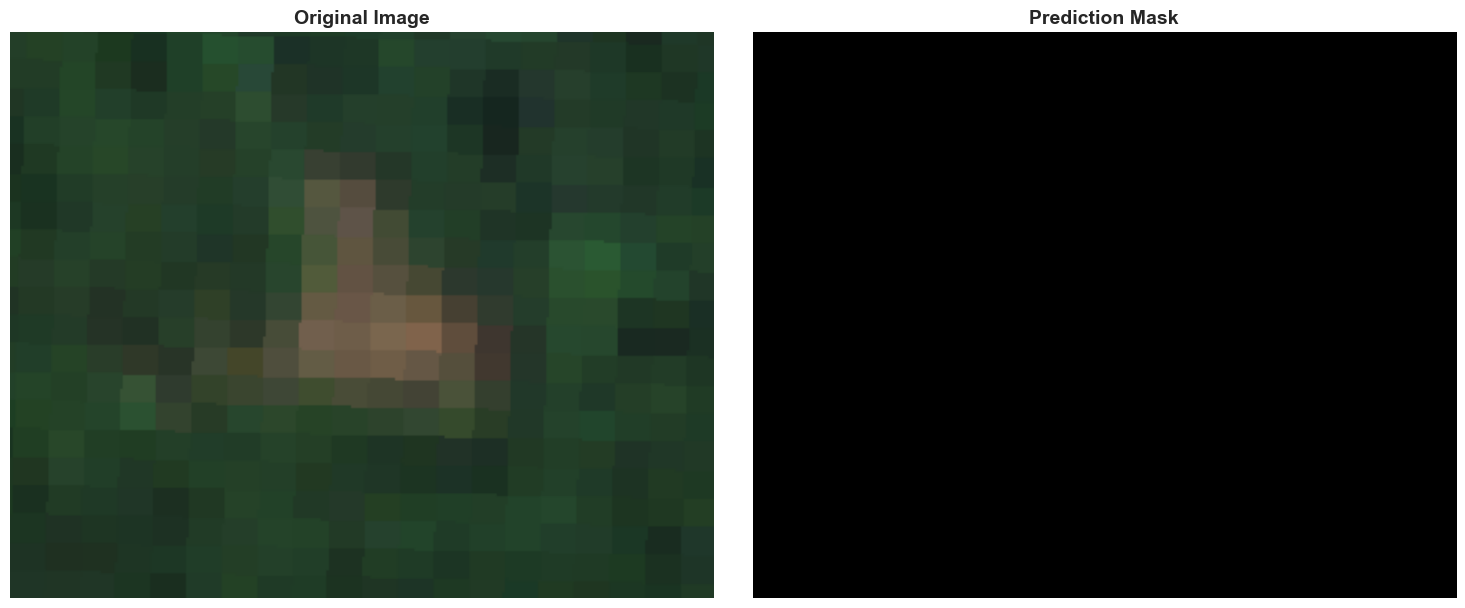

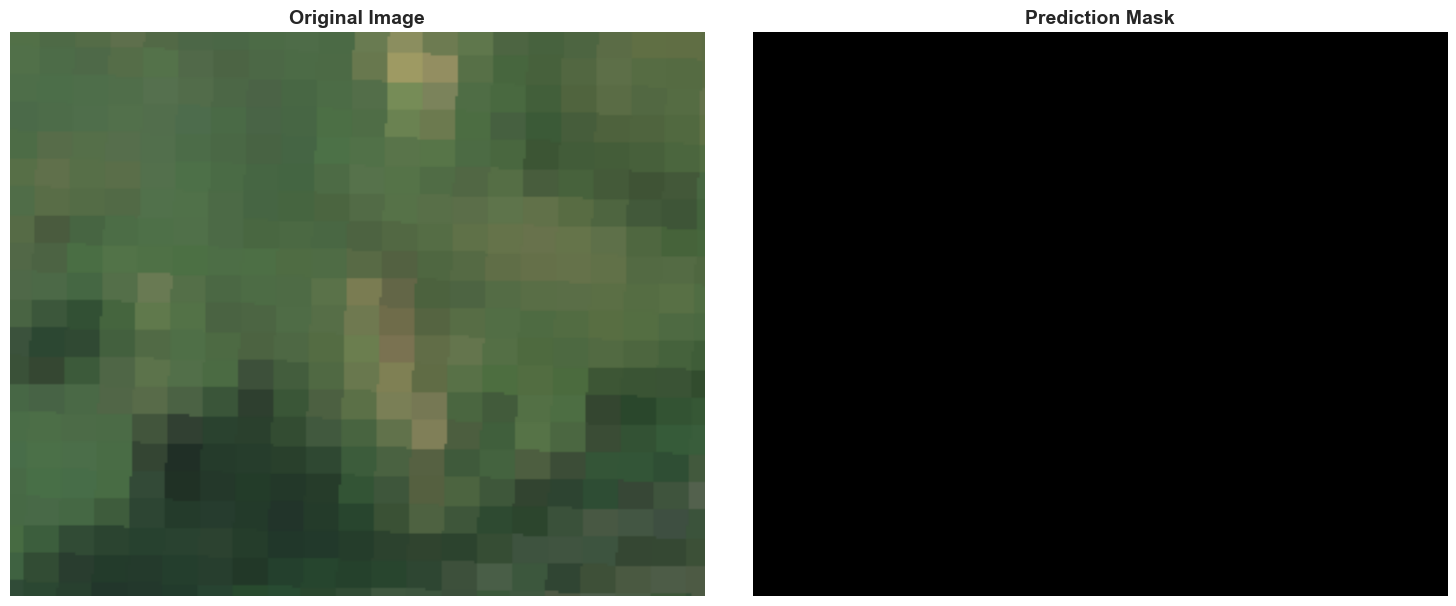

In [84]:
auckland_dir = './data/2-data-explore-events'

imgs = [
    '0_174.701880487593_-36.931306466746_2023-02-13_2023-03-06',
    '16_174.603559053774_-37.0492662414968_2023-01-29_2023-02-19',
    '7968_174.575889109309_-36.9510233656217_2023-01-29_2023-02-19',
    '7975_174.575279574077_-36.9584351646335_2023-01-29_2023-02-19',
    '7996_174.59173891446_-36.9652471775134_2023-01-29_2023-02-19',
    '8866_174.567747838123_-36.5191367689426_2023-01-29_2023-02-19'
]

for img_name in imgs:
    img = f"{auckland_dir}/images/{img_name}.png"
    predict = f"{auckland_dir}/predictions/{img_name}_mask.png"
    visualize_segmentation_results(img, predict)
